# Dataset Analysis and Pipeline Validation
## Image-Based Product Category Classification

This notebook covers the initial analysis of the raw dataset and validates the effectiveness of our automated data preparation pipeline.

The goals of this notebook are to:
- Inspect the raw dataset and its original category distribution.
- **Validate the new category structure** created by our NLP-based merging script.
- **Analyze the balance of the final, merged dataset**.
- Verify data quality, such as the validity of image URLs.

In [15]:
# Import tools needed for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from concurrent.futures import ThreadPoolExecutor

plt.style.use("default")

## 1. Loading the Dataset

The dataset is provided as two CSV files, the first one contains product title, image URLs and category id.
The categories.csv, has the categories names.
Due to its size, the dataset is hosted externally and downloaded using a dedicated script.

In [16]:
products_df = pd.read_csv("../data/raw/products.csv")
categories_df = pd.read_csv("../data/raw/categories.csv")
products_df.head()

asin                                              title  \
0  B014TMV5YE  Sion Softside Expandable Roller Luggage, Black...   
1  B07GDLCQXV  Luggage Sets Expandable PC+ABS Durable Suitcas...   
2  B07XSCCZYG  Platinum Elite Softside Expandable Checked Lug...   
3  B08MVFKGJM  Freeform Hardside Expandable with Double Spinn...   
4  B01DJLKZBA  Winfield 2 Hardside Expandable Luggage with Sp...   

                                              imgUrl  \
0  https://m.media-amazon.com/images/I/815dLQKYIY...   
1  https://m.media-amazon.com/images/I/81bQlm7vf6...   
2  https://m.media-amazon.com/images/I/71EA35zvJB...   
3  https://m.media-amazon.com/images/I/91k6NYLQyI...   
4  https://m.media-amazon.com/images/I/61NJoaZcP9...   

                             productURL  stars  reviews   price  listPrice  \
0  https://www.amazon.com/dp/B014TMV5YE    4.5        0  139.99       0.00   
1  https://www.amazon.com/dp/B07GDLCQXV    4.5        0  169.99     209.99   
2  https://www.amazon.com/dp/B07XSCCZYG    4.6        0  365.49     429.99   
3  https://www.amazon.com/dp/B08MVFKGJM    4.6        0  291.59     354.37   
4  https://www.amazon.com/dp/B01DJLKZBA    4.5        0  174.99     309.99   

   category_id  isBestSeller  boughtInLastMonth  
0          104         False               2000  
1          104         False               1000  
2          104         False                300  
3          104         False                400  
4          104         False                400

In [17]:
print(f"Number of samples: {len(products_df)}")
print(f"Number of columns: {len(products_df.columns)}")
products_df.columns

Number of samples: 1426337
Number of columns: 11


Index(['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price',
       'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth'],
      dtype='object')

- The dataset contains product title, image URLs and their corresponding category id.
- The category labels are stored in a seperate csv file.
- The following analysis focuses on cleaning and refining these fields.

## 2. Raw Category Inspection

We first examine the distribution of all available categories to understand their frequency and suitability for image-based classification.

In [18]:
raw_category_counts = products_df["category_id"].value_counts()
print(categories_df[["id","category_name"]].head())

print("\nMin frequency of a category: " + str(raw_category_counts.min()))
print("Max frequency of a category: " + str(raw_category_counts.max()))
print("Mean frequency of a category: " + str(int(raw_category_counts.mean())))

   id                     category_name
0   1          Beading & Jewelry Making
1   2                 Fabric Decorating
2   3       Knitting & Crochet Supplies
3   4              Printmaking Supplies
4   5  Scrapbooking & Stamping Supplies

Min frequency of a category: 22
Max frequency of a category: 28619
Mean frequency of a category: 5751


## 3. Automated Category Merging

The original dataset contains 248 categories, many of which are either too specific, too broad, or semantically very similar. A manual approach to filtering or merging is not scalable or reproducible.

Also there are some categories that have a few products in them, and can unbalance the dataset.

To solve this, we implemented an automated pipeline that uses **NLP (Sentence-Transformers) and Clustering (K-Means)** to group the 248 original categories into a more manageable and balanced set of around 50 new categories. 

The following steps analyze the result of that pipeline.

First, we load the final processed dataset and the mapping file generated by our scripts.

In [19]:
# Load the results of the new data preparation pipeline
products_cleaned_df = pd.read_csv("../data/processed/products_cleaned.csv")
mapping_df = pd.read_csv("../data/processed/category_mapping.csv")

print(f"Loaded {len(products_cleaned_df)} cleaned products.")
print(f"Loaded mapping for {len(mapping_df)} original categories into {mapping_df['merged_category_id'].nunique()} new categories.")

Loaded 1421985 cleaned products.
Loaded mapping for 235 original categories into 47 new categories.


For securing the dataset, categories with fewer than 100 samples were removed to ensure
a more balanced and learnable dataset.

After modifying, the final category set is obtained.
These categories are visually distinguishable and suitable for classification.


## 4. Dataset Balance Analysis

We analyze the number of samples per category to assess dataset balance.

In [20]:
# Getting ready for visualization
category_counts = products_cleaned_df["merged_category_id"].value_counts()
category_counts_df = (
    category_counts
    .reset_index()
)
category_counts_df.columns = ["merged_category_id", "count"]
category_counts_df = category_counts_df.merge(
    mapping_df,
    on="merged_category_id",
    how="left"
)

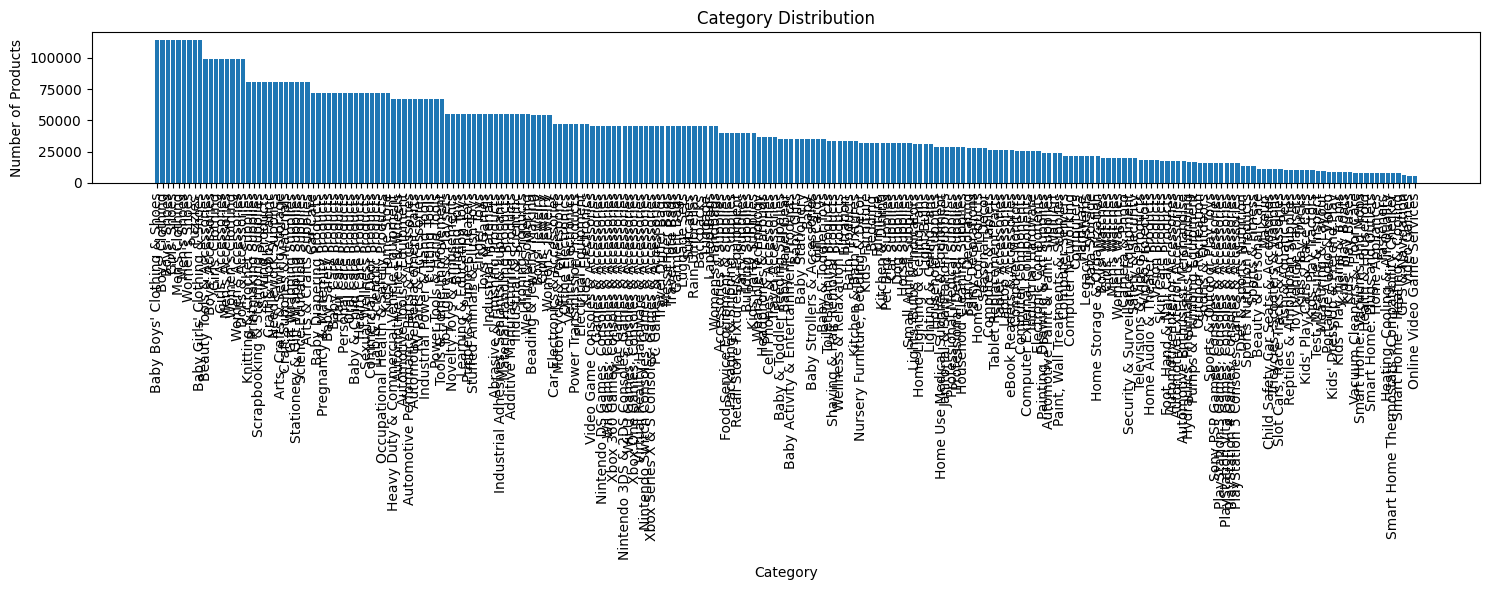

In [21]:
plt.figure(figsize=(15, 6))

plt.bar(
    category_counts_df["category_name"],
    category_counts_df["count"]
)

plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.title("Category Distribution")

plt.tight_layout()
plt.show()

The graph shows some amount imbalance across categories.
This imbalance will be addressed in later phases using data augmentation and training strategies.

## 5. Image URL Quality Check

To assess data quality, we verify whether image URLs are reachable.
Due to dataset size, this check is performed on a random subset.


In [22]:
def is_url_valid(url):
    try:
        r = requests.get(
            url,
            timeout=5,
            stream=True,
            allow_redirects=True,
            headers={"User-Agent": "Mozilla/5.0"}
        )
        return r.status_code == 200
    except requests.RequestException:
        return False
    
def check_urls_parallel(urls, max_workers=40):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for res in tqdm(executor.map(is_url_valid, urls), total=len(urls)):
            results.append(res)
    return results

sample_df = products_cleaned_df.sample(200, random_state=42).copy()

sample_df["valid"] = check_urls_parallel(
    sample_df["imgUrl"].tolist(),
    max_workers=20
)

sample_df["valid"].value_counts()

100%|██████████| 200/200 [00:18<00:00, 10.71it/s]


valid
True     198
False      2
Name: count, dtype: int64

The sample-based validation indicates that most image URLs are reachable.
Invalid URLs are removed automatically during the image download and training stage, where missing images will be skipped.

## 6. Example Images from Each Category

To better understand the visual characteristics of each category and verify that
categories are visually distinguishable, we display a small number of example
images from each category.

For each category, 2–3 sample images are randomly selected and visualized.

In [23]:
import os
import time
import hashlib
import requests
from PIL import Image
from io import BytesIO

# Base cache directory
IMAGE_CACHE_DIR = "../data/raw/images"
os.makedirs(IMAGE_CACHE_DIR, exist_ok=True)

def _url_to_filename(url):
    """
    Create a deterministic filename from a URL using hashing.
    """
    return hashlib.md5(url.encode("utf-8")).hexdigest() + ".jpg"


def load_image_from_url(
    url,
    timeout=5,
    retries=3,
    backoff=1.0,
    cache_dir=IMAGE_CACHE_DIR
):
    """
    Fetch an image from a URL with caching and retries.

    If the image was previously downloaded, it is loaded from disk
    instead of downloading again.

    Args:
        url (str): Image URL
        timeout (int): Request timeout in seconds
        retries (int): Number of retry attempts
        backoff (float): Seconds to wait between retries
        cache_dir (str): Directory for cached images

    Returns:
        PIL.Image or None
    """
    filename = _url_to_filename(url)
    filepath = os.path.join(cache_dir, filename)

    # 1 -> Load from cache if exists
    if os.path.exists(filepath):
        try:
            return Image.open(filepath).convert("RGB")
        except Exception:
            # Corrupted cache → remove and re-download
            os.remove(filepath)

    # 2 -> Download with retries
    for attempt in range(1, retries + 1):
        try:
            response = requests.get(url, timeout=timeout)
            response.raise_for_status()

            # Ensure it's an image
            if "image" not in response.headers.get("Content-Type", ""):
                raise ValueError("URL did not return an image")

            img = Image.open(BytesIO(response.content)).convert("RGB")

            # Save to cache
            img.save(filepath, format="JPEG", quality=90)

            return img

        except Exception:
            if attempt < retries:
                time.sleep(backoff)
            else:
                return None

In [24]:
def fetch_image(row):
    """
    Fetch image for a single dataframe row.
    Returns (category, image or None).
    """
    img = load_image_from_url(row["imgUrl"])
    return row["merged_category_id"], img

In [25]:
images_per_category = 2
rows = []
categories = products_cleaned_df["merged_category_id"].unique()
n_rows = len(categories)
n_cols = images_per_category

for category in categories:
    category_df = products_cleaned_df[
        products_cleaned_df["merged_category_id"] == category
    ]
    sampled = category_df.sample(
        min(images_per_category, len(category_df)),
        random_state=42
    )
    rows.extend(sampled.to_dict("records"))

images = []

with ThreadPoolExecutor(max_workers=20) as executor:
    for result in tqdm(
        executor.map(fetch_image, rows),
        total=len(rows),
        desc="Downloading images"
    ):
        images.append(result)

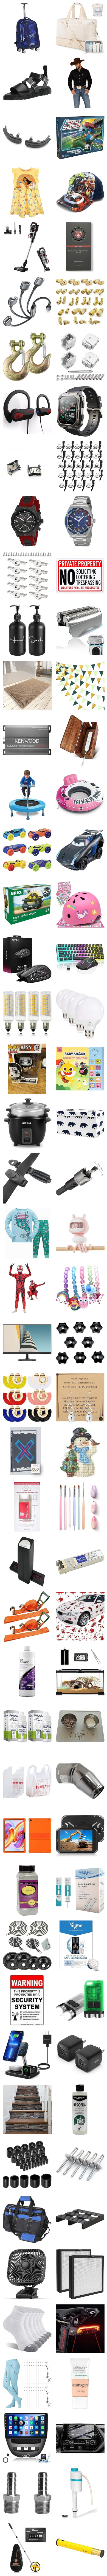

In [26]:
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 2, n_rows * 2)
)

idx = 0
for row_idx, category in enumerate(categories):
    for col_idx in range(images_per_category):
        ax = axes[row_idx][col_idx]
        img_category, img = images[idx]

        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Image\nNot Available",
                    ha="center", va="center")

        ax.axis("off")

        if col_idx == 0:
            ax.set_ylabel(str(category), rotation=0, labelpad=40)

        idx += 1
# plt.title("Example Images from Each Category")
plt.tight_layout()
plt.show()

The example images demonstrate that the selected categories are visually distinct
and suitable for image-based classification. This qualitative inspection supports
the feasibility of the proposed learning task.

## 7. Image Dimension Distribution

Images collected from online marketplaces often vary significantly in resolution.
To analyze this variability and justify image resizing during preprocessing,
we examine the distribution of image widths and heights.

A random sample of 1000 images is used for this analysis.

In [27]:
# Sample images
SAMPLE_SIZE = 1000
sample_df = products_cleaned_df.sample(
    min(SAMPLE_SIZE, len(products_cleaned_df)),
    random_state=42
)

def get_image_size(url):
    img = load_image_from_url(url)
    if img is not None:
        return img.size  # (width, height)
    return None

sizes = []

with ThreadPoolExecutor(max_workers=20) as executor:
    for size in tqdm(
        executor.map(get_image_size, sample_df["imgUrl"]),
        total=len(sample_df),
        desc="Fetching image dimensions"
    ):
        if size is not None:
            sizes.append(size)

print(f"Collected dimensions for {len(sizes)} images")

Fetching image dimensions: 100%|██████████| 1000/1000 [00:00<00:00, 1454.04it/s]

Collected dimensions for 1000 images


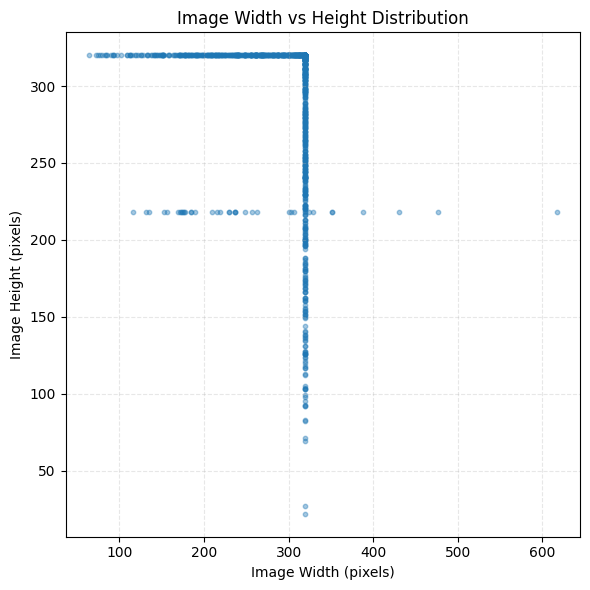

In [28]:
widths, heights = zip(*sizes)

plt.figure(figsize=(6, 6))
plt.scatter(widths, heights, alpha=0.4, s=10)
plt.xlabel("Image Width (pixels)")
plt.ylabel("Image Height (pixels)")
plt.title("Image Width vs Height Distribution")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

The scatter plot shows a wide variation in image dimensions across the dataset.
Both width and height span a large range of values, indicating that images are
not captured or stored at a consistent resolution.

This variability motivates the use of image resizing as a necessary
preprocessing step before model training to ensure consistent input dimensions.

## 8. Training Pipeline
To have a high level view and a brief explanation, during training phase, we do the Augmentation process:
- **Resize:** To a uniform `224x224` pixels.
- **RandomHorizontalFlip:** p=0.5.
- **RandomRotation:** 15 degrees.
- **ColorJitter:** brightness=0.2, contrast=0.2, saturation=0.2.
- **ToTensor:** Convert PIL Image to PyTorch Tensor.
- **Normalize:** Use standard ImageNet mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]`.

For validation and testing we do only:
- **Resize:** `224x224` pixels.
- **ToTensor:** Convert to Tensor.
- **Normalize:** Use the same mean and std as the training pipeline.

## Summary

In this notebook, we performed a full cycle of data analysis and pipeline validation:
- We began by inspecting the **raw dataset** and its original, imbalanced category structure.
- We then loaded the results of our **automated NLP-based category merging pipeline**.
- We **visualized the final dataset's balance**, confirming that the new 50 categories are much more evenly distributed.
- We reviewed the mapping to understand how original categories were grouped.
- We verified the quality of image URLs in the dataset.

The resulting dataset, `products_cleaned.csv`, is now validated and ready to serve as the foundation for model training.